# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [2]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [3]:
print(len(human_files))
print(human_files)

13233
['/data/lfw/Dan_Ackroyd/Dan_Ackroyd_0001.jpg'
 '/data/lfw/Alex_Corretja/Alex_Corretja_0001.jpg'
 '/data/lfw/Daniele_Bergamin/Daniele_Bergamin_0001.jpg' ...,
 '/data/lfw/Ferenc_Madl/Ferenc_Madl_0002.jpg'
 '/data/lfw/Jim_Flaherty/Jim_Flaherty_0001.jpg'
 '/data/lfw/Stacey_Yamaguchi/Stacey_Yamaguchi_0001.jpg']


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


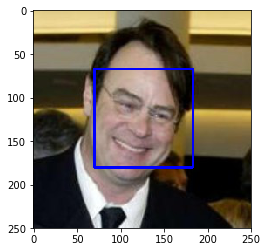

In [49]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()



Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [45]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ <br> 
Below output shows the percentage of faces detected in human files which are =97 <br>
Percentage of dogs detected in human files = 17

In [90]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

### returns "True" if a dog is detected in the image stored at img_path
count_human=0
for human in human_files_short:
    result=face_detector(human)
    count_human+=result
    
print(count_human)  

count_dog=0
for dog in dog_files_short:
    result=face_detector(dog)
    count_dog+=result
    
print(count_dog)  


98
17


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [44]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [43]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image

    
    in_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
    
    image=Image.open(img_path).convert('RGB') 
    image = in_transform(image)
    if use_cuda:
        image = image.cuda()
    image=image.unsqueeze(0)


    #print((image.size()))
    #print(image,type(image))
    prediction = VGG16(image)
    
    return torch.max(prediction, 1)[1] # predicted class index

In [91]:
# will take input path of the image as input and give a prediction
VGG16_predict(dog_files_short[0])


tensor([ 208], device='cuda:0')

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [46]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    # get the index 
    ten_index=VGG16_predict(img_path)
    # convert to value
    ten_item= ten_index.item()
    
    if 151<ten_item<268:
        return True
    else:
        return False

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ Below uutput cell shows the solution<br>
Number of dogs in human file = 0 <br>
Number of dogs in dog file = 92

In [11]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
count_human=0
for human in human_files_short:
    result=dog_detector(human)
    count_human+=result
    
print(count_human)  


count_dog=0
for dog in dog_files_short:
    result=dog_detector(dog)
    count_dog+=result
    
print(count_dog) 

0
98


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [7]:
## Make a series of Imports for future use


import torch
import torchvision.models as models

from PIL import Image
import torchvision.transforms as transforms

import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline       


use_cuda = torch.cuda.is_available()

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [8]:
import os
from torchvision import datasets

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes


# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
#valid_size = 0.2
                                         
                                              
# convert data to a normalized torch.FloatTensor
transform=transforms.Compose([

    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  # so that pixel values are in range from 0 to 1
])


transform_valid=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  # so that pixel values are in range from 0 to 1
])

# define training and test data directories
data_dir = '/data/dog_images/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')
valid_dir= os.path.join(data_dir, 'valid/')


train_data=datasets.ImageFolder(train_dir,transform=transform)
test_data=datasets.ImageFolder(test_dir,transform=transform_valid)
valid_data=datasets.ImageFolder(valid_dir,transform=transform_valid)

# Prepare data loaders ( They give us a way to iterate over the data,one batch at a time)
train_loader= torch.utils.data.DataLoader(train_data,batch_size=batch_size,num_workers=num_workers,shuffle = True)
test_loader=torch.utils.data.DataLoader(test_data,batch_size=batch_size,num_workers=num_workers)
valid_loader=torch.utils.data.DataLoader(valid_data,batch_size=batch_size,num_workers=num_workers)



loaders_scratch = {
    'train': train_loader,
    'test': test_loader,    
    'valid': valid_loader
}

In [9]:
num_classes=133

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:<br>
All the data resizing was sone to make the images of the shape (224,224). Further images were normalized using mean subtraction <br>
Further,
Data Augmentation was done through a series of operations including - RandomResizing, RandomHorizontal Flipping and Random Rotation. This was done after lot of overfitting was observed on validation set. <br>




### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [16]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 224x224x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1,stride=2)  # (inchannels, out_channels,kernel_size) out channels= No of channels produced by the convolution
        # convolutional layer (sees 56x56x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1,stride=2)
        # convolutional layer (sees 14x14x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        # convolutional layer (sees 7x7x64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)  # no maxpool in this layer
        # max pooling layer        
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (128 * 7 * 7 -> 500)
        self.fc1 = nn.Linear(128 *7*7, 500) #(input feature, output features)
        # linear layer (500 -> 133)
        self.fc2 = nn.Linear(500, num_classes)
        # dropout layer (p=0.3)
        self.dropout = nn.Dropout(0.3)
        
    
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        #x = self.dropout(x)        
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = (F.relu(self.conv4(x)))  # no maxpool         
        # flatten image input
        x = x.view(-1, 128*7*7)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x
      
#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.3)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ <br> I found this part to be pretty challenging, Initially, I started with a normal VGG16 architecture, which didnot gave a very good performance. I added another layer and modified the values of droput etc to finally get an architecture which gives a better performance. Below are the details of the complete architecture: <br>
The First Convolutional layer accepts the preprocessed images which are 224 x 224 x3. Then there is a series of Convolutional and MaxPool Layers which keep extracting the features from the initial layers of the network. Then the extracted feature are finally ded to the linear layers to give the probability of the best class being predicted from the classifier. Below diagram sums up the architecture. The Layer defines whether its a Convolutional/ MaxPool/ Linear layer. Input dimension and output dimension defines the width of the image being passed before and after the layer.


In [1]:
%%html
<img src="./Images_2/Capture.PNG", width=600,height=600>

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [23]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.04)
#optimizer = optim.SGD(model_scratch.parameters(), lr = 0.01, momentum=0.3)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [7]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        
        # Add mode.train() to separate training and validation phase
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            #print(data.size())
            #print(target.size())
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            
            output = model(data)
            #print(output.size())
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %(epoch, batch_idx + 1, train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
       # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_scratch.pt') #torch.save(the_model, PATH)
            valid_loss_min = valid_loss

    # return trained model
    return model



In [25]:
# train the model

model_scratch = train(30, loaders_scratch, model_scratch, optimizer_scratch, criterion_scratch, use_cuda, 'model_scratch.pt')


Epoch 1, Batch 1 loss: 4.286103
Epoch 1, Batch 101 loss: 3.841307
Epoch 1, Batch 201 loss: 3.844363
Epoch 1, Batch 301 loss: 3.842238
Epoch: 1 	Training Loss: 3.852776 	Validation Loss: 3.855124
Validation loss decreased (inf --> 3.855124).  Saving model ...
Epoch 2, Batch 1 loss: 3.434848
Epoch 2, Batch 101 loss: 3.812197
Epoch 2, Batch 201 loss: 3.816268
Epoch 2, Batch 301 loss: 3.824032
Epoch: 2 	Training Loss: 3.821358 	Validation Loss: 3.921995
Epoch 3, Batch 1 loss: 3.509787
Epoch 3, Batch 101 loss: 3.785081
Epoch 3, Batch 201 loss: 3.773857
Epoch 3, Batch 301 loss: 3.780870
Epoch: 3 	Training Loss: 3.787121 	Validation Loss: 3.839127
Validation loss decreased (3.855124 --> 3.839127).  Saving model ...
Epoch 4, Batch 1 loss: 3.580213
Epoch 4, Batch 101 loss: 3.751649
Epoch 4, Batch 201 loss: 3.732257
Epoch 4, Batch 301 loss: 3.731897
Epoch: 4 	Training Loss: 3.732641 	Validation Loss: 3.854077
Epoch 5, Batch 1 loss: 3.710192
Epoch 5, Batch 101 loss: 3.703215
Epoch 5, Batch 201 lo

In [ ]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [29]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.617744


Test Accuracy: 18% (151/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [22]:
# Data Loaders same as defined above for normal model
loaders_transfer = loaders_scratch.copy()

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [23]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 

#LetsTry With ResNet 101 Architecture !!

model_transfer = models.resnet101(pretrained=True)

if use_cuda:
    model_transfer = model_transfer.cuda()

In [24]:
num_classes=133

In [25]:
print(model_transfer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [26]:
# Freeze all the parameters required gradient to False
for param in model_transfer.parameters():
    param.requires_grad = False

In [27]:
last_layer_features = model_transfer.fc.in_features   # the number of existing features of the last layer
model_transfer.fc = nn.Linear(last_layer_features, num_classes)  # Update the current layer

In [28]:
if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ <br>
Resnet 101 https://arxiv.org/abs/1512.03385, architecture was used for Transfer learning.<br>
The ResNet architecture in itself amazing. ResNet is a deep neural net architectire, that won state of the competitions like ImageDetection, COCO Detection.<br> It allows easy flow of gradients and helps with Vanishing Gradient problem, to train deep Neural Nets.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [30]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [31]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            #print(data.size())
            #print(target.size())
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            
            output = model(data)
            #print(output.size())
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %(epoch, batch_idx + 1, train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
       # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_transfer.pt') #torch.save(the_model, PATH)
            valid_loss_min = valid_loss

    # return trained model
    return model


In [32]:
# train the transfer learning model
model_transfer =  train(10, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')


Epoch 1, Batch 1 loss: 5.000893
Epoch 1, Batch 101 loss: 4.915692
Epoch 1, Batch 201 loss: 4.877079
Epoch 1, Batch 301 loss: 4.837587
Epoch: 1 	Training Loss: 4.825082 	Validation Loss: 4.643011
Validation loss decreased (inf --> 4.643011).  Saving model ...
Epoch 2, Batch 1 loss: 4.856402
Epoch 2, Batch 101 loss: 4.672975
Epoch 2, Batch 201 loss: 4.626853
Epoch 2, Batch 301 loss: 4.601912
Epoch: 2 	Training Loss: 4.593299 	Validation Loss: 4.392252
Validation loss decreased (4.643011 --> 4.392252).  Saving model ...
Epoch 3, Batch 1 loss: 4.529939
Epoch 3, Batch 101 loss: 4.452139
Epoch 3, Batch 201 loss: 4.426902
Epoch 3, Batch 301 loss: 4.399420
Epoch: 3 	Training Loss: 4.392372 	Validation Loss: 4.158429
Validation loss decreased (4.392252 --> 4.158429).  Saving model ...
Epoch 4, Batch 1 loss: 4.050891
Epoch 4, Batch 101 loss: 4.244730
Epoch 4, Batch 201 loss: 4.233830
Epoch 4, Batch 301 loss: 4.206594
Epoch: 4 	Training Loss: 4.196504 	Validation Loss: 3.912657
Validation loss de

In [34]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [35]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 2.797157


Test Accuracy: 62% (519/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [37]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

# print(type(class_names))
print(class_names[:10])

['Affenpinscher', 'Afghan hound', 'Airedale terrier', 'Akita', 'Alaskan malamute', 'American eskimo dog', 'American foxhound', 'American staffordshire terrier', 'American water spaniel', 'Anatolian shepherd dog']


In [38]:
if use_cuda:
    model_transfer = model_transfer.cuda()

In [39]:
def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image = Image.open(img_path)
    image = image.convert('RGB')
    #print(image)
    transform = transforms.Compose([transforms.Resize(size=(224,224)), 
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
    
    image = transform(image)
    if use_cuda:
        image = image.cuda()
    image=image.unsqueeze(0)
    #print(type(image))
    prediction = model_transfer(image) # will give out the list of probabilities
    #print(prediction)
    #prediction_index=torch.max(prediction)
    prediction_index=torch.max(prediction, 1)[1]
    prediction_name= class_names[prediction_index]
    return prediction_name

In [40]:
# Test Over all the existing images in the image directory under project folder
'''
for img in os.listdir('./images'):
    img_path = os.path.join('./images', img)
    prediction_name = predict_breed_transfer(img_path)
    print("Image name : {} , Predicted Cateogary of Dog: {}".format(img_path.split('/')[2], prediction_name))
'''

'\nfor img in os.listdir(\'./images\'):\n    img_path = os.path.join(\'./images\', img)\n    prediction_name = predict_breed_transfer(img_path)\n    print("Image name : {} , Predicted Cateogary of Dog: {}".format(img_path.split(\'/\')[2], prediction_name))\n'

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [50]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    # open the image
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    #img.show()
    if dog_detector(img_path):
        print("Woof Woof , Dog Detected !!!!")
        prediction = predict_breed_transfer(img_path)
        print("Hello Dog!, Your Predicted Breed is: {}". format(prediction))
    elif face_detector(img_path):
        print("Human Detected :) ")
        prediction = predict_breed_transfer(img_path)
        print("Hello, human!, You may look like a {}".format(prediction))
    else:
        print("Error!!, neither human nor dog :)")
    

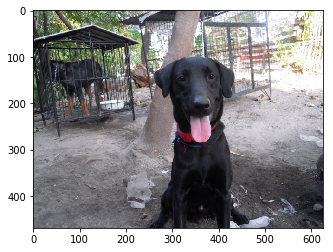

Woof Woof , Dog Detected !!!!
Hello Dog!, Your Predicted Breed is: Flat-coated retriever


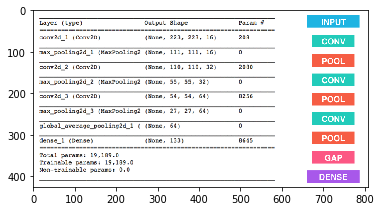

Error!!, neither human nor dog :)


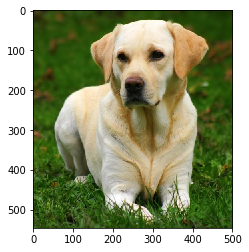

Woof Woof , Dog Detected !!!!
Hello Dog!, Your Predicted Breed is: Golden retriever


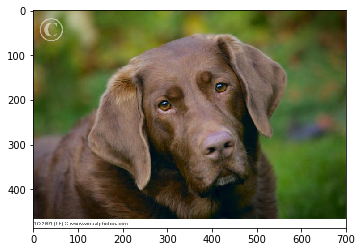

Woof Woof , Dog Detected !!!!
Hello Dog!, Your Predicted Breed is: Chesapeake bay retriever


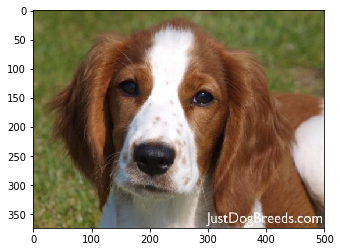

Woof Woof , Dog Detected !!!!
Hello Dog!, Your Predicted Breed is: Cavalier king charles spaniel


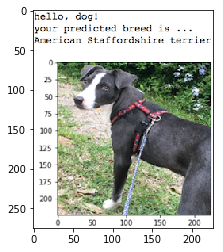

Woof Woof , Dog Detected !!!!
Hello Dog!, Your Predicted Breed is: Boston terrier


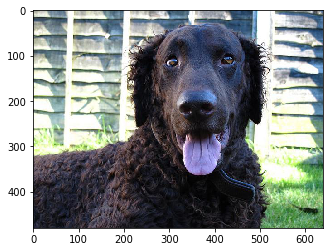

Woof Woof , Dog Detected !!!!
Hello Dog!, Your Predicted Breed is: Curly-coated retriever


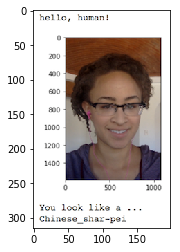

Human Detected :) 
Hello, human!, You may look like a Affenpinscher


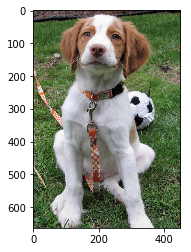

Woof Woof , Dog Detected !!!!
Hello Dog!, Your Predicted Breed is: Brittany


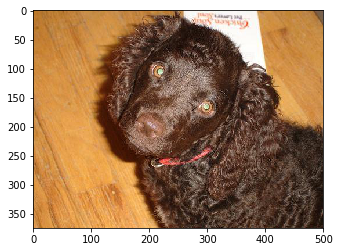

Woof Woof , Dog Detected !!!!
Hello Dog!, Your Predicted Breed is: Curly-coated retriever


In [51]:
# Run the app

# Test Over all the existing images in the image directory under project folder

for img in os.listdir('./images'):
    img_path = os.path.join('./images', img)
    run_app(img_path)

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ <br> I tried out with 7 different images. I tried with three different iamges of dogs, including my own dog :) and it could detect all the images of the dogs correctly.<br>
Then I tried with two of human images( Luke SkyWalker from Star Wars !!). Since one image of the images was not clear it couldnt detect that. Finally, I tried with Yoda's ( Star Wars again :)) image , and it correctly marked it as neither human nor dog, sice he is neither human nor dog( one with Force :)). <br>
I think overall the app did a pretty amazing job :)
<br> Three possible points for improvement:
-  I could have tried with different architectures , if more resources available
-  More hyperparameter tuning could provide better results.
-  More training data, could have helped :)


In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.


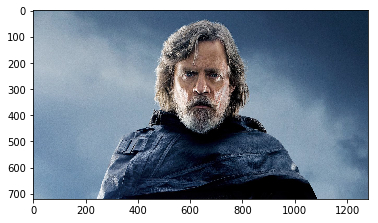

Woof Woof , Dog Detected !!!!
Hello Dog!, Your Predicted Breed is: Beauceron


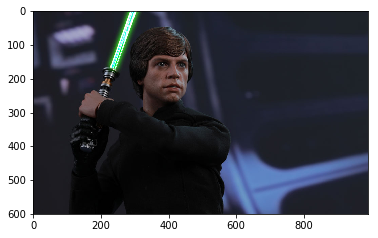

Human Detected :) 
Hello, human!, You may look like a Cavalier king charles spaniel


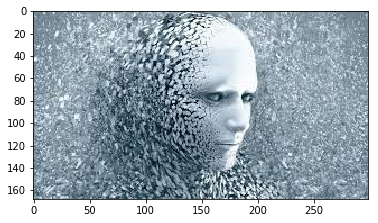

Human Detected :) 
Hello, human!, You may look like a Bichon frise


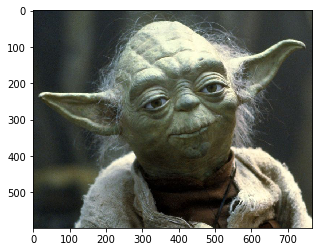

Error!!, neither human nor dog :)


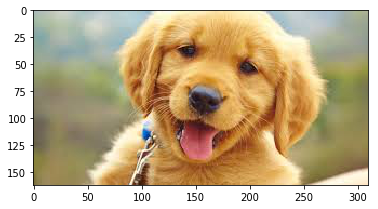

Woof Woof , Dog Detected !!!!
Hello Dog!, Your Predicted Breed is: Golden retriever


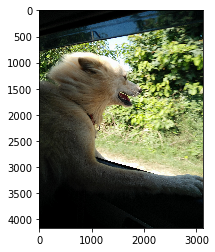

Woof Woof , Dog Detected !!!!
Hello Dog!, Your Predicted Breed is: Afghan hound


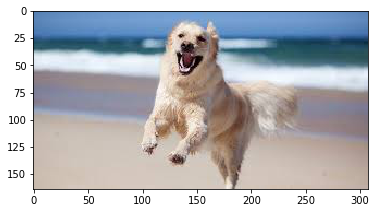

Woof Woof , Dog Detected !!!!
Hello Dog!, Your Predicted Breed is: Afghan hound


In [68]:

for img in os.listdir('./Images_2'):
    img_path = os.path.join('./Images_2', img)
    if img_path.endswith('jpg'):
        run_app(img_path)
    
